In [1]:
import pandas as pd
import numpy as np
import datetime

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Relationship with Macro Economic Variable

In [234]:
# from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, rmspe, aic
from statsmodels.graphics.tsaplots import  plot_acf, plot_pacf, plot_predict

In [5]:
hose = pd.read_csv("cleaned data/VNINDEX_2000_2020.csv", index_col = "Date")
hnx = pd.read_csv("cleaned data/HNXINDEX_2005_2020.csv", index_col = "Date")

hose.index = pd.to_datetime(hose.index)
hnx.index = pd.to_datetime(hnx.index)

In [124]:
# Filter out month end values
def filter_month_end(og_df):
    df = pd.DataFrame()
    df["Date"] = og_df.index
    df["Month"] = [ i.month for i in og_df.index ]
    df["Year"] = [ i.year for i in  og_df.index ]
    month_df = df[["Month","Year","Date"]].groupby(["Year","Month"], as_index = False ).agg({"Date":"max"})

    return month_df.merge(og_df, on = "Date", how = "left", suffixes = [None, "_x"])[["Year", "Month", "Date", "Close"]]

# Merge index data with macroeconomic dat
def make_macro_df(index_month_df, monthly_macro_df, index_name, vars_):
    index_macro = index_month_df.merge(monthly_macro_df, on = ["Year", "Month"],
                                         how = "inner", suffixes = [None, "_x"])
    index_macro.index = pd.to_datetime(index_macro[['Year', 'Month']].assign(DAY=1))
    index_macro = index_macro[vars_].dropna()
    index_macro.set_index(pd.date_range(start = index_macro.index.min(),
                                        periods =len(index_macro),
                                        freq="M"), inplace= True)
    index_macro.rename(columns = {"Close":index_name}, inplace = True)
    return index_macro

# Condect and print result of Augmented Dickey Fuller Test
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

hose_month = filter_month_end(hose)
hnx_month = filter_month_end(hnx)

In [83]:
monthly_macro_df = pd.read_csv("cleaned data/IMF composite/month_macro_extra.csv", thousands = ",")
monthly_macro_df.columns

Index(['Time',
       'Economic Activity, Industrial Production, Energy, Electricity Production, Index',
       'Economic Activity, Industrial Production, Index',
       'Economic Activity, Industrial Production, Manufacturing, Index',
       'Economic Activity, Industrial Production, Mining, Index',
       'Exchange Rates, Domestic Currency per SDR, Period Average',
       'Exchange Rates, Domestic Currency per U.S. Dollar, Period Average, Rate',
       'Financial, Interest Rates, Deposit, Percent per annum',
       'Financial, Interest Rates, Monetary Policy-Related Interest Rate, Percent per annum',
       'Prices, Consumer Price Index, All items, Index'],
      dtype='object')

In [84]:
# Filter out relevant variables
# monthly_macro_df.dropna(subset = ["Economic Activity, Industrial Production, Index"],  inplace = True)

monthly_macro_df = monthly_macro_df[['Time', 'Economic Activity, Industrial Production, Index',
                        'Financial, Interest Rates, Deposit, Percent per annum',
                        'Exchange Rates, Domestic Currency per SDR, Period Average',
                        'Prices, Consumer Price Index, All items, Index']]

macro_vals ={'Economic Activity, Industrial Production, Index':"IIP",
                'Exchange Rates, Domestic Currency per SDR, Period Average':"EXR_SDR",
                'Financial, Interest Rates, Deposit, Percent per annum':"IR_DEPOSIT", 
                'Prices, Consumer Price Index, All items, Index':"CPI" }

monthly_macro_df.rename(columns = macro_vals, inplace=True)
monthly_macro_df["Time"] = pd.to_datetime( monthly_macro_df["Time"])
monthly_macro_df["Month"] = [ i.month for i in monthly_macro_df["Time"]]
monthly_macro_df["Year"] = [ i.year for i in monthly_macro_df["Time"]]

monthly_macro_df.head()

,Time,IIP,IR_DEPOSIT,EXR_SDR,CPI,Month,Year
0,2000-01-01,NaN,3.6,19241.56,48.57,1,2000
1,2000-02-01,NaN,3.6,18905.93,49.33,2,2000
2,2000-03-01,NaN,3.6,18881.99,48.77,3,2000
3,2000-04-01,NaN,3.6,18832.44,48.41,4,2000
4,2000-05-01,NaN,3.6,18452.45,48.13,5,2000


In [100]:
# Merge month end values of stock indeces with macroeconomic variables and scale by taking log
hose_macro = make_macro_df( hose_month,monthly_macro_df, "VNX-INDEX", ["Close","EXR_SDR", "IIP","IR_DEPOSIT", "CPI"])
hose_macro = np.log(hose_macro)
hnx_macro = make_macro_df( hnx_month,monthly_macro_df, "HNX-INDEX", ["Close","EXR_SDR", "IIP","IR_DEPOSIT", "CPI"])
hnx_macro = np.log(hnx_macro)

## Testing all variables for Unit Root

Augmented Dickey-Fuller Test: VNX-INDEX
ADF Statistic: -0.120620
p-value: 0.947346
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: Differenced VNX-NDEX
ADF Statistic: -4.877119
p-value: 0.000039
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579


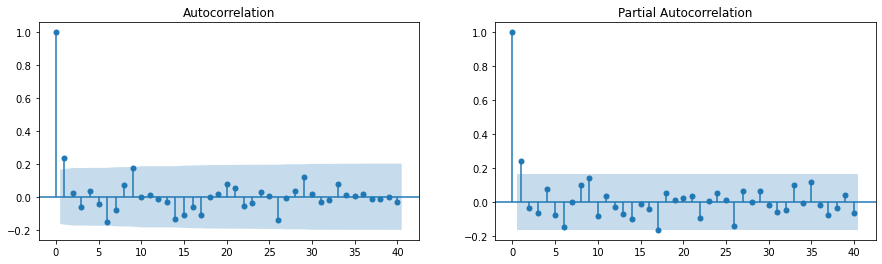

In [32]:
# Stock Indeces
print(f'Augmented Dickey-Fuller Test: VNX-INDEX')
augmented_dickey_fuller_statistics(hose_macro["VNX-INDEX"])
print(f'Augmented Dickey-Fuller Test: Differenced VNX-NDEX')
augmented_dickey_fuller_statistics(hose_macro["VNX-INDEX"].diff().dropna())
# Graph hose_macro
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(hose_macro['VNX-INDEX'].diff()[1:], lags=40, ax=axes[0])
fig = plot_pacf(hose_macro['VNX-INDEX'].diff()[1:], lags=40, ax=axes[1])

Augmented Dickey-Fuller Test: HNX-INDEX
ADF Statistic: -1.643453
p-value: 0.460457
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Augmented Dickey-Fuller Test: Differenced HNX-NDEX
ADF Statistic: -3.991207
p-value: 0.001457
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579


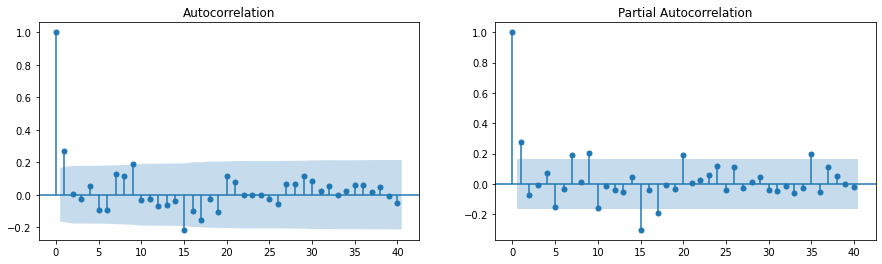

In [34]:
print(f'Augmented Dickey-Fuller Test: HNX-INDEX')
augmented_dickey_fuller_statistics(hnx_macro["HNX-INDEX"])
print(f'Augmented Dickey-Fuller Test: Differenced HNX-NDEX')
augmented_dickey_fuller_statistics(hnx_macro["HNX-INDEX"].diff().dropna())
#Graph hnx-index
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(hnx_macro['HNX-INDEX'].diff()[1:], lags=40, ax=axes[0])
fig = plot_pacf(hnx_macro['HNX-INDEX'].diff()[1:], lags=40, ax=axes[1])

In [15]:
# Macroeconomic Variables
for col in ["IIP", "IR_DEPOSIT","EXR_SDR","CPI"]:
    print(f'Augmented Dickey-Fuller Test: {col}')
    augmented_dickey_fuller_statistics(hose_macro[col])
    print(f'Augmented Dickey-Fuller Test: Differenced {col}')
    augmented_dickey_fuller_statistics(hose_macro[col].diff().dropna())
    print("\n")

Augmented Dickey-Fuller Test: IIP
ADF Statistic: -3.010515
p-value: 0.033924
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: Differenced IIP
ADF Statistic: -2.706793
p-value: 0.072870
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579


Augmented Dickey-Fuller Test: IR_DEPOSIT
ADF Statistic: -1.752950
p-value: 0.404058
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578
Augmented Dickey-Fuller Test: Differenced IR_DEPOSIT
ADF Statistic: -6.824459
p-value: 0.000000
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578


Augmented Dickey-Fuller Test: EXR_SDR
ADF Statistic: -2.229063
p-value: 0.195867
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578
Augmented Dickey-Fuller Test: Differenced EXR_SDR
ADF Statistic: -8.192609
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


Augmented Dickey-Fuller Test: CPI
ADF Statistic: -2.121516
p-value: 0.235951
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578
Augmented Dickey-Fu

In [127]:
# Excluding IIP which is not Unit Root
hose_macro = make_macro_df( hose_month,monthly_macro_df, "VNX-INDEX", ["Close","EXR_SDR", "IR_DEPOSIT", "CPI"])
hose_macro = np.log(hose_macro)
hnx_macro = make_macro_df( hnx_month,monthly_macro_df, "HNX-INDEX", ["Close","EXR_SDR", "IR_DEPOSIT", "CPI"])
hnx_macro = np.log(hnx_macro)

## Vector Error Correction Model
### Fitting VECM model with VNX-INDEX

In [189]:
vec_rank1 = select_coint_rank(hose_macro.loc["2005-07-31":"2020-01-31"], 
                              det_order = 1,
                              k_ar_diff = 1, 
                              method = 'maxeig',
                              signif=0.05)
print(vec_rank1.summary())
select_order(hose_macro, maxlags = 10, deterministic="colo").summary()

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          36.95          30.82
  1   2          13.18          24.25
-------------------------------------


,AIC,BIC,FPE,HQIC
0,-29.30,-28.89,1.878e-13,-29.14
1,-29.87,-29.22*,1.068e-13,-29.61*
2,-29.88*,-28.99,1.056e-13*,-29.52
3,-29.81,-28.69,1.134e-13,-29.36
4,-29.78,-28.42,1.168e-13,-29.23
5,-29.77,-28.17,1.187e-13,-29.12
6,-29.73,-27.90,1.232e-13,-28.99
7,-29.66,-27.60,1.321e-13,-28.83
8,-29.63,-27.33,1.366e-13,-28.71
9,-29.60,-27.06,1.426e-13,-28.57


In [218]:
vecm = VECM(endog = hose_macro.loc["2005-07-31":"2020-02-28"], 
            k_ar_diff = 1, 
            coint_rank = 1, 
            deterministic = "colo")
hose_vecm_fit = vecm.fit()
hose_vecm_fit.summary().tables[-1]

,coef,std err,z,P>|z|,[0.025,0.975]
beta.1,1.0000,0,0,0.000,1.000,1.000
beta.2,-6.1619,1.564,-3.939,0.000,-9.228,-3.096
beta.3,1.1083,0.217,5.099,0.000,0.682,1.534
beta.4,4.5571,0.971,4.694,0.000,2.654,6.460


In [229]:
hose_vecm_fit.test_granger_causality( caused = "VNX-INDEX", causing= ['EXR_SDR', 'IR_DEPOSIT', 'CPI'], signif = 0.05).summary() 

Test statistic,Critical value,p-value,df
1.334,2.113,0.240,"(6, 632)"


In [226]:
hose_vecm_fit.test_inst_causality( causing= [ 'EXR_SDR', 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
7.389,7.815,0.060,3


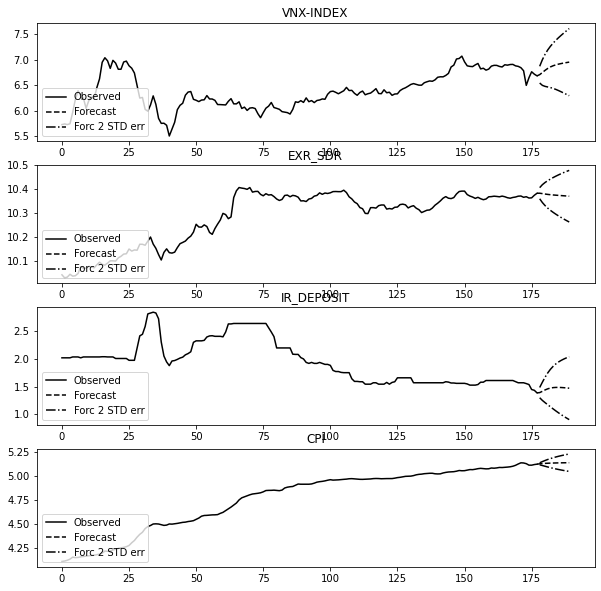

In [194]:
hose_vecm_fit.plot_forecast(steps = 12)

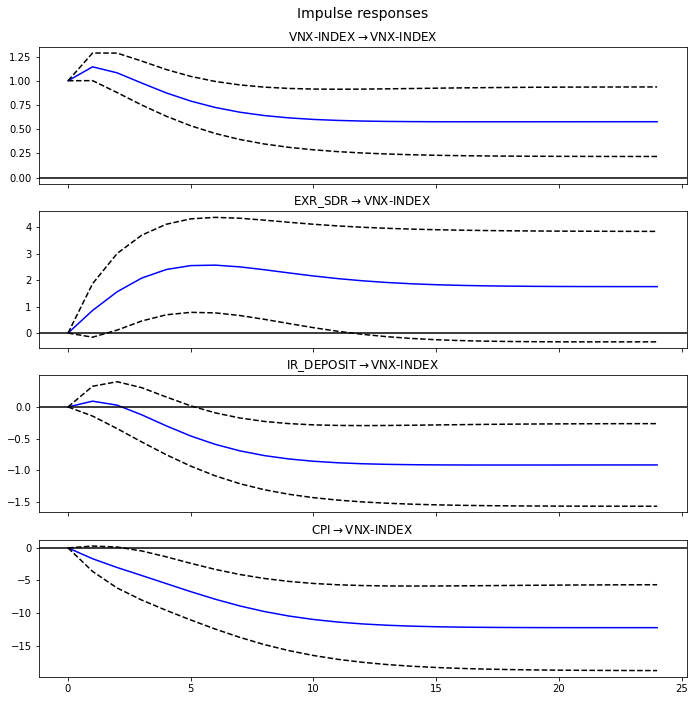

In [195]:
_ = hose_vecm_fit.irf(24).plot(response = "VNX-INDEX", orth=False)

In [196]:
hose_vecm_fit.test_normality().summary()

Test statistic,Critical value,p-value,df
1114.,15.51,0.000,8


In [199]:
hose_vecm_fit.test_whiteness(nlags=5, adjusted=True).summary()

Test statistic,Critical value,p-value,df
81.28,79.08,0.035,60


### HNX

In [202]:
vec_rank1 = select_coint_rank(hnx_macro.loc["2005-07-31":"2020-06-30"], 
                              det_order = 1,
                              k_ar_diff = 1, 
                              method = 'maxeig',
                              signif=0.05)
print(vec_rank1.summary())
select_order(hnx_macro.loc["2005-07-31":"2020-06-30"], maxlags = 10, deterministic="colo").summary()

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          30.12          30.82
-------------------------------------


,AIC,BIC,FPE,HQIC
0,-29.34,-28.82,1.820e-13,-29.12
1,-30.10,-29.28*,8.510e-14,-29.76*
2,-30.07,-28.96,8.698e-14,-29.62
3,-30.14*,-28.73,8.196e-14*,-29.57
4,-30.06,-28.36,8.881e-14,-29.37
5,-30.01,-28.01,9.395e-14,-29.20
6,-30.10,-27.80,8.599e-14,-29.17
7,-29.99,-27.40,9.666e-14,-28.94
8,-29.96,-27.07,1.005e-13,-28.79
9,-29.96,-26.77,1.019e-13,-28.67


In [215]:
vecm = VECM(endog = hnx_macro.loc["2005-07-31":"2020-02-28"], 
            k_ar_diff = 2, 
            coint_rank = 1, 
            deterministic = "colo")
hnx_vecm_fit = vecm.fit()
hnx_vecm_fit.summary().tables[-1]

,coef,std err,z,P>|z|,[0.025,0.975]
beta.1,1.0000,0,0,0.000,1.000,1.000
beta.2,-3.3416,2.836,-1.178,0.239,-8.899,2.216
beta.3,1.7117,0.403,4.251,0.000,0.923,2.501
beta.4,3.5179,1.743,2.019,0.044,0.103,6.933


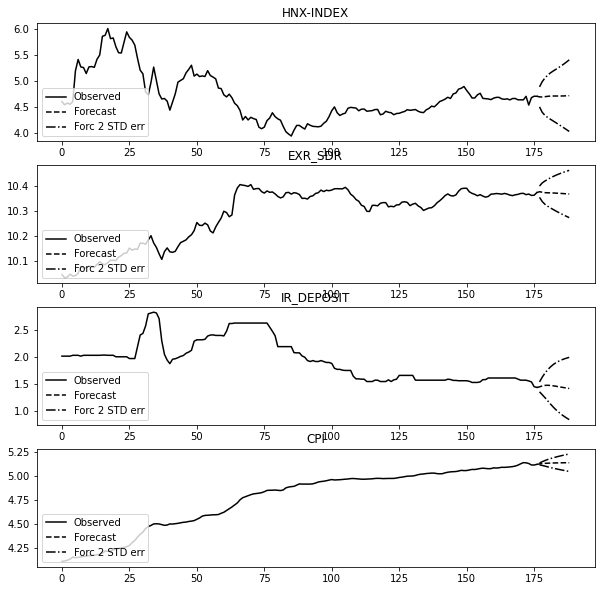

In [204]:
hnx_vecm_fit.plot_forecast(steps = 12)

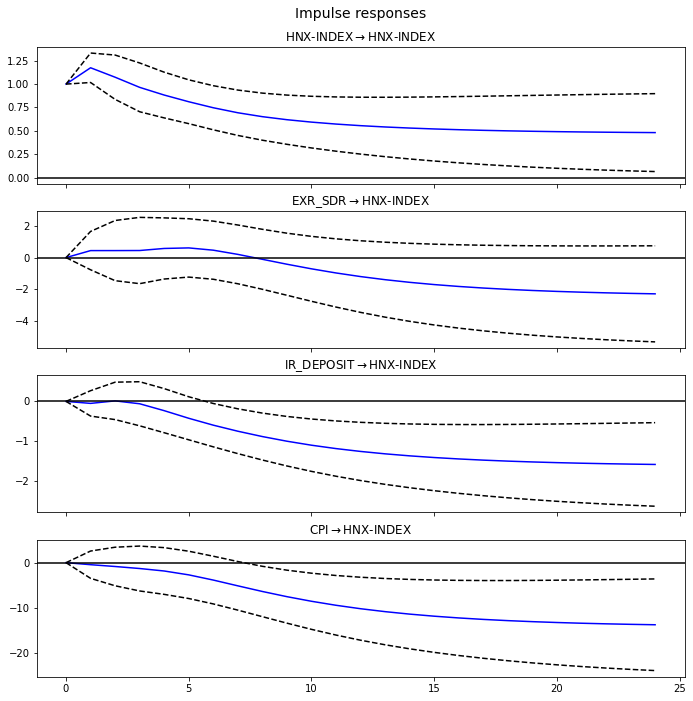

In [216]:
_ = hnx_vecm_fit.irf(24).plot(response = "HNX-INDEX", orth=False)

In [230]:
hnx_vecm_fit.test_granger_causality( caused = "HNX-INDEX", causing= ['EXR_SDR', 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
0.4775,1.895,0.890,"(9, 612)"


In [227]:
hnx_vecm_fit.test_inst_causality( causing= [ 'EXR_SDR', 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
19.01,7.815,0.000,3


In [206]:
hnx_vecm_fit.test_normality().summary()

Test statistic,Critical value,p-value,df
1124.,15.51,0.000,8


In [217]:
hnx_vecm_fit.test_whiteness(nlags=5, adjusted=True).summary()

Test statistic,Critical value,p-value,df
67.79,60.48,0.012,44


## Fitting SARIMAX Models

In [154]:
def plot_predictions(data, full_res, cutoff, dynamic_cutoff,title, ylable):
    # One-step ahead
    predict = full_res.get_prediction()
    predict_ci = predict.conf_int()
    # Dynamic predictions
    predict_dy = full_res.get_prediction(dynamic= dynamic_cutoff)
    predict_dy_ci = predict_dy.conf_int()
    # Graph
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 4
    ax.set(title=title, xlabel='Date', ylabel=ylable)

    # Plot data points
    data.loc[cutoff:, title].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    # One-step-ahead
    predict.predicted_mean.loc[cutoff:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = predict_ci.loc[cutoff:]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    # Dynamix
    predict_dy.predicted_mean.loc[cutoff:].plot(ax=ax, style='g', label=f'Dynamic forecast({dynamic_cutoff}) ')
    ci = predict_dy_ci.loc[cutoff:]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
    legend = ax.legend(loc='lower right')

### HOSE

In [209]:
endog = hose_macro.loc[:,"VNX-INDEX"]
exog = hose_macro.loc[:,['EXR_SDR', 'IR_DEPOSIT', 'CPI'] ]

# Fit the model
hose_mod = sm.tsa.statespace.SARIMAX(endog.loc[:"2020-02-28"], exog.loc[:"2020-02-28"], order=(1,1,1))
hose_fit_tr = hose_mod.fit(disp=False)
print(hose_fit_tr.summary())

                               SARIMAX Results                                
Dep. Variable:              VNX-INDEX   No. Observations:                  235
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 234.127
Date:                Fri, 09 Apr 2021   AIC                           -456.253
Time:                        21:12:19   BIC                           -435.521
Sample:                    07-31-2000   HQIC                          -447.894
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXR_SDR       -0.0709      0.424     -0.167      0.867      -0.902       0.761
IR_DEPOSIT    -0.0772      0.101     -0.767      0.443      -0.275       0.120
CPI           -0.3871      0.696     -0.556      0.5

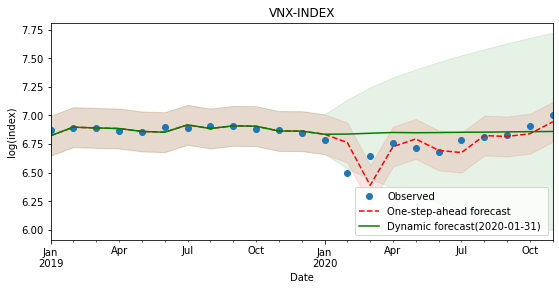

In [241]:
hose_full_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,1,1))
hose_fit_full = hose_full_mod.filter(hose_fit_tr.params)
plot_predictions(hose_macro, hose_fit_full, "2019-01-31", "2020-01-31", "VNX-INDEX", "log(index)")

### HNX

In [157]:
endog = hnx_macro.loc[:,"HNX-INDEX"]
exog = hnx_macro.loc[:,['EXR_SDR', 'IR_DEPOSIT', 'CPI'] ]

# Fit the model
hnx_mod = sm.tsa.statespace.SARIMAX(endog.loc[:"2020-06-30"], exog.loc[:"2020-06-30"], order=(1,1,1))
hnx_fit_tr = hnx_mod.fit(disp=False)
print(hnx_fit_tr.summary())

                               SARIMAX Results                                
Dep. Variable:              HNX-INDEX   No. Observations:                  180
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 157.264
Date:                Fri, 09 Apr 2021   AIC                           -302.529
Time:                        20:59:22   BIC                           -283.404
Sample:                    07-31-2005   HQIC                          -294.774
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXR_SDR        0.2047      0.603      0.340      0.734      -0.976       1.386
IR_DEPOSIT    -0.0196      0.151     -0.130      0.897      -0.315       0.276
CPI           -3.0194      0.863     -3.497      0.0

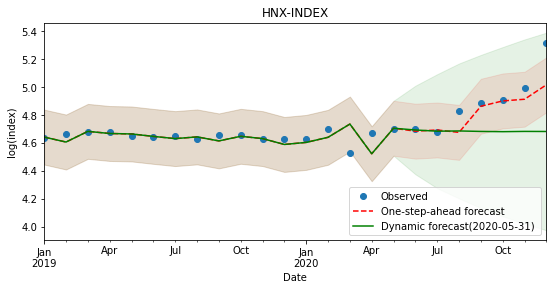

In [243]:
hnx_full_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,1,1))
hnx_fit_full = hnx_full_mod.filter(hnx_fit_tr.params)
plot_predictions(hnx_macro, hnx_fit_full, "2019-01-31", "2020-05-31", "HNX-INDEX", "log(index)")

### Evaluate models

In [235]:
hose_predict = hose_fit_full.get_prediction()
hose_tr_pred = hose_predict.predicted_mean.loc[:"2020-02-28"]
hose_te_pred = hose_predict.predicted_mean.loc["2020-02-28":]
print("VNX-INDEX:")
print("In sample RMSE:", rmse(hose_macro.loc[:"2020-02-28","VNX-INDEX"], hose_tr_pred))
print("In sample RMSPE:", rmspe(hose_macro.loc[:"2020-02-28","VNX-INDEX"], hose_tr_pred))
print("Out sample RMSE:", rmse(hose_macro.loc["2020-02-28":,"VNX-INDEX"], hose_te_pred))
print("Out sample RMSPE:", rmspe(hose_macro.loc["2020-02-28":,"VNX-INDEX"], hose_te_pred))

VNX-INDEX:
In sample RMSE: 0.459499671534216
In sample RMSPE: 0.9869748166391695
Out sample RMSE: 0.12857950143755542
Out sample RMSPE: 0.19457697330688017


In [244]:
hnx_predict = hnx_fit_full.get_prediction()
hnx_tr_pred = hnx_predict.predicted_mean.loc[:"2020-02-28"]
hnx_te_pred = hnx_predict.predicted_mean.loc["2020-02-28":]
print("HNX-INDEX:")
print("In sample RMSE:", rmse(hnx_macro.loc[:"2020-02-28","HNX-INDEX"], hnx_tr_pred))
print("In sample RMSPE:", rmspe(hnx_macro.loc[:"2020-02-28","HNX-INDEX"], hnx_tr_pred))
print("Out sample RMSE:", rmse(hnx_macro.loc["2020-02-28":,"HNX-INDEX"], hnx_te_pred))
print("Out sample RMSPE:", rmspe(hnx_macro.loc["2020-02-28":,"HNX-INDEX"], hnx_te_pred))

HNX-INDEX:
In sample RMSE: 1.1340249054311506
In sample RMSPE: 2.4653339912082752
Out sample RMSE: 0.1303826644731438
Out sample RMSPE: 0.2640136408240822
